In [1]:
# Project library Imports
from lc_tutorials.appearance.notebook import apply_custom_styles, cprint
from lc_tutorials.appearance.displays import display_tavily_search_results
from lc_tutorials.functionality.utils import setup_environment

# Standard library imports
import os
import sys
import json
import time
import random
from typing import Annotated
from typing_extensions import TypedDict
from IPython.display import display, HTML, Markdown, Image, Javascript

# Third-party imports
from dotenv import load_dotenv, find_dotenv
from colorama import Back, Fore, Style, init
from langchain_community.tools.tavily_search import TavilySearchResults

# LangGraph Imports
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import ToolNode, tools_condition

# LangChain Imports
from langchain_core.messages import ToolMessage
from langchain_openai import ChatOpenAI


custom_style="""
<style>
/* General styles */
.result-container {
    max-width: 90%;
    margin: 1em 0;
}

/* Card Styling */
.result-card {
    background-color: #f8f9fa;
    border-left: 4px solid #05bfa5;
    border-radius: 8px;
    margin-bottom: 1em;
    overflow: hidden;
}

/* Header Styling */
.result-header {
    display: flex;
    justify-content: space-between;
    align-items: center;
    padding: 0.8em 1em;
    font-family: 'Source Code Pro', monospace;
    font-weight: bold;
    font-size: 1.05em;
    color: #2c3e50;
    background-color: #e9ecef;
    cursor: pointer;
}

.result-header:hover {
    background-color: #dfe4ea;
}

/* Content Styling */
.result-content {
    display: none;
    padding: 0.8em 1em;
    font-family: 'Source Code Pro', monospace;
    font-size: 0.95em;
    color: #34495e;
}

/* Link Styling */
.result-link {
    text-decoration: none;
    color: #3498db;
    font-weight: bold;
}
</style>

<script>
// JavaScript function to toggle visibility of the result content and icon
function toggleContent(id, iconId) {
    var content = document.getElementById(id);
    var icon = document.getElementById(iconId);
    if (content.style.display === "none" || content.style.display === "") {
        content.style.display = "block";
        icon.innerHTML = "&#9660;";  // Change to down-facing arrow
    } else {
        content.style.display = "none";
        icon.innerHTML = "&#9654;";  // Change to right-facing arrow
    }
}
</script>
"""
apply_custom_styles(use_base=True, custom_style=custom_style)
setup_environment()

def is_message_a_tool_call(message):
    return hasattr(message, "tool_calls") and len(message.tool_calls) > 0


✅ Environment Variables Loaded Successfully



<div class="h1-container">

# 🚀 Quick Start <sub> ··· continued!</sub>

In this comprehensive quick start, we will build a support chatbot in LangGraph that can:

<div class="feature-list">

- 🧠 Answer common questions w/ a basic chatbot
- 🔍 Answer common questions by searching the web
- <span style="color: teal; font-weight: bold;">💾 Maintain conversation state across calls [THIS NOTEBOOK]</span>
- 🔄 Route complex queries to a human for review
- ⚙️ Use custom state to control its behavior
- 🌳 Rewind and explore alternative conversation paths

</div>

<br>

Previously we built a basic chatbot, and one that could operate tools... we will now enhance our ChatBot with <b>memory</b>. 

</div>

<div class="h2-container">

## Part 3: Adding Memory to the Chatbot

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

<div class="notice-block">
<h4 style="margin-top: 0; color: #ff5722;">ENHANCING CONVERSATION CAPABILITIES!</h4>
<p>
    LangGraph addresses this issue through persistent checkpointing. By providing a checkpointer during graph compilation and specifying a <code>thread_id</code> when calling the graph, LangGraph automatically saves the state after each interaction. When invoked again with the same <code>thread_id</code>, the graph loads its saved state, enabling the chatbot to continue the conversation seamlessly.
</p>
</div>

<div class="h3-container">

### 🔄 Benefits of Persistent Checkpointing

<br>

<div class="note-block">
    <p class="note-title">📌 Overview</p>
    <p>Checkpointing goes beyond simple memory by enabling advanced conversational features, such as:</p>
    <ul>
        <li><strong>Error Recovery:</strong> Resume from specific states in case of errors.</li>
        <li><strong>Human-in-the-Loop Workflows:</strong> Allowing human oversight and adjustments in conversation.</li>
        <li><strong>Time Travel Interactions:</strong> Go back to previous states for revisiting or modifying responses.</li>
    </ul>
</div>

---

<div class="notice-block">
    <span class="highlight">💡 Tip:</span> Checkpointing is not limited to conversation memory; it supports more complex state management, making it ideal for scenarios where context continuity is essential.
</div>

<br>

<b>🛠 Creating a MemorySaver Checkpointer</b>
To enable multi-turn conversations, initialize a <code class="code-mention">MemorySaver</code> checkpointer, which will handle the saving and loading of conversational states, allowing the chatbot to maintain context over multiple interactions.

<div class="note-block">
    <p class="note-title">📝 MemorySaver Overview</p>
    <p><strong>MemorySaver</strong> is a base in-memory checkpoint saver that inherits from <code class="code-mention">BaseCheckpointSaver</code>, <code class="code-mention">AbstractContextManager</code>, and <code class="code-mention">AbstractAsyncContextManager</code>.</p>
    <p>This checkpoint saver stores checkpoints in memory using a <code class="code-mention">defaultdict</code>, making it lightweight and suitable for debugging or testing. For production applications, however, it is recommended to use <strong>PostgresSaver</strong> or <strong>AsyncPostgresSaver</strong> (available in <code class="code-mention">langgraph-checkpoint-postgres</code>), which provide more robust and persistent storage.</p>
    <br>
    <p><strong>Notable Parameters:</strong></p>
    <ul>
        <li><strong>serde (Optional[SerializerProtocol], default: None):</strong> The serializer used for serializing and deserializing checkpoints. This defaults to <code class="code-mention">None</code> but can be customized for specific use cases.</li>
    </ul>
</div>

<br>

</div>


In [2]:
memory = MemorySaver()

memory.__dict__

{'serde': <langgraph.checkpoint.serde.jsonplus.JsonPlusSerializer at 0x106b4ed80>,
 'storage': defaultdict(<function langgraph.checkpoint.memory.MemorySaver.__init__.<locals>.<lambda>()>,
             {}),
 'writes': defaultdict(dict, {})}

<div class="h3-container">
    
### 📉 Defining the Graph with Memory

<p>In this step, we define the graph for our chatbot's memory-enhanced functionality. Previously, we constructed a custom graph using <code class="code-mention">BasicToolNode</code>, but now we'll leverage LangGraph’s prebuilt <code class="code-mention">ToolNode</code> and <code class="code-mention">tools_condition</code>. These components streamline our workflow by adding capabilities like parallel API execution and enhanced tool coordination.</p>

<div class="note-block">
    <p class="note-title">🔹 Why Use Prebuilt Components?</p>
    <p><strong>ToolNode</strong> and <strong>tools_condition</strong> offer optimized performance for tool integration, allowing us to handle multiple requests concurrently and manage complex data flows without additional configuration. This simplifies the architecture, making it more efficient for real-time applications.</p>
</div>

<p>By binding tools directly to our language model, we ensure that whenever the chatbot needs to call our search engine or other tools, it generates output in the correct JSON format automatically. This structured approach allows the chatbot to seamlessly query external APIs, retrieve responses, and deliver accurate information to users.</p>

</div>

In [3]:
class State(TypedDict):
    """Defines the state schema for the chatbot graph.
    
    Attributes:
        messages (Annotated[list, add_messages]): List of conversation messages.
            Uses add_messages reducer to append rather than overwrite messages.
    """
    messages: Annotated[list, add_messages]
    

def initialize_graph():
    """Initialize the StateGraph with the defined State schema.
    
    Returns:
        StateGraph: Configured graph builder instance
    """
    return StateGraph(State)


def chatbot(state: State) -> dict:
    """Process the current state and generate a response using the language model.
    
    Args:
        state (State): Current state containing conversation messages
        
    Returns:
        dict: Updated state with new message appended
    """
    return {"messages": [llm.invoke(state["messages"])]}

# Initialize the graph builder
graph_builder = initialize_graph()

# Initialize our tool
tool = TavilySearchResults(max_results=2)

# Initialize the language model
llm = ChatOpenAI(model="gpt-4o")
llm = llm.bind_tools([tool,])

# Add the chatbot and tool nodes to the graph
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

# Add the conditional edge using the prebuilt `tools_condition`
graph_builder.add_conditional_edges("chatbot", tools_condition,)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

print(graph_builder)
display(graph_builder.__dict__)

{'nodes': {'chatbot': StateNodeSpec(runnable=chatbot(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None, input=<class '__main__.State'>, retry_policy=None),
  'tools': StateNodeSpec(runnable=tools(tags=None, recurse=True, func_accepts_config=True, func_accepts={'writer': False, 'store': True}, tools_by_name={'tavily_search_results_json': TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))}, tool_to_state_args={'tavily_search_results_json': {}}, tool_to_store_arg={'tavily_search_results_json': None}, handle_tool_errors=True), metadata=None, input=<class '__main__.State'>, retry_policy=None)},
 'edges': {('__start__', 'chatbot'), ('tools', 'chatbot')},
 'branches': defaultdict(dict,
             {'chatbot': {'tools_condition': Branch(path=tools_condition(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), ends=None, th

<div class="h3-container">

### 🔄 Finalizing the Graph with Checkpointing

<p><strong>Finally</strong>, compile the graph using the provided checkpointer.</p>

<code class="code-mention">graph = graph_builder.compile(checkpointer=memory)

<p>Note that the graph’s connectivity remains unchanged from Part 2. The only addition here is the <strong>checkpointing</strong> of the state at each node, which allows the graph to save progress as it processes each step.</p>

<p>This setup enables the chatbot to pick up from where it left off, enhancing conversation continuity without altering the existing structure. By storing the state in real-time, checkpointing ensures a smooth and persistent user experience across multiple interactions.</p>

</div>



🧜‍♀️ Mermaid Chart for Our Graph



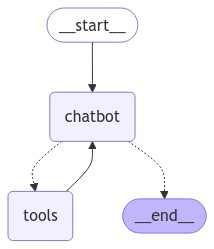

In [4]:
graph = graph_builder.compile(checkpointer=memory)

cprint("\n🧜‍♀️ Mermaid Chart for Our Graph\n", fg_color="blue", bold=True)
display(Image(graph.get_graph().draw_mermaid_png()))

<div class="h3-container">

### 🗂 Managing Context with Configurations and Checkpoints

<p>We start by choosing a thread to use as the key for this conversation.</p>

<code class="code-mention">config = {"configurable": {"thread_id": "1"}}</code>

<p>Now when we call <code class="code-mention">graph.stream</code> we can pass our config object and we will be able to tap into the existing conversation!</p>

<p><strong>Notice</strong> the conversation memory isn't managed through an external list or storage system; instead, it's entirely handled by the checkpointer! Each conversation thread is assigned a unique configuration, allowing the chatbot to maintain context within the specified <code class="code-mention">thread_id</code>. This setup enables the bot to "remember" past exchanges and deliver responses in context without external memory tracking.</p>

<p>To inspect this in action, we could try using a different configuration to initiate a fresh conversation:</p>

<code class="code-mention">{"configurable": {"thread_id": "2"}}</code>

<p>Since the <code class="code-mention">thread_id</code> is different, the chatbot will treat this as a new conversation, demonstrating that checkpoints provide isolated context handling for each thread.</p>

<div class="notice-block">
    <p><strong>Tip:</strong> The <code>get_state(config)</code> method allows you to inspect the graph's state for a given configuration at any point in time. A state snapshot will display all conversation details, the current config, and the next node in the process. This feature is useful for debugging and tracing your chatbot’s memory handling across threads.</p>
</div>

<p>Now let's actually run the chatbot with this configuration</p>

</div>


In [5]:
config = {"configurable": {"thread_id": "1"}}

<div class="h3-container">

### 🤖 Running Your Chatbot

Let's run our bot...<br><b>We can now ask the bot questions outside its training data!</b><br><br>We've added some prettified features to make things look a bit better...

<div class="feature-list">

- 🎯 Interactive chat interface with colorized output
- 🚪 Multiple exit commands supported
- 🛡️ Error handling and graceful fallbacks
- 🔄 Stream-based response processing
- 💬 Message history tracking

</div>

</div>


In [6]:
def run_interactive_chat(graph: CompiledStateGraph) -> None:
    """Run the interactive chat interface with enhanced printing capabilities.

    Args:
        graph (CompiledStateGraph): The compiled LangGraph instance
    """
    EXIT_COMMANDS = {"quit", "exit", "q", "bye", "goodbye"}
    message_history = []
    
    # Display welcome banner
    cprint("\n"+"="*50, fg_color="blue", bold=True)
    cprint("🦜 Welcome to LangGraph Chat!", fg_color="yellow", bold=True)
    cprint("Type 'quit', 'exit', 'bye', 'goodbye', or 'q' to end the conversation", fg_color="white", bold=True)
    cprint("="*50+"\n", fg_color="blue", bold=True)

    # Start interaction loop
    while True:
        try:
            # Get user input with styled prompt
            user_input = input("\nUser Input: ")
            
            # Check for exit command
            if user_input.lower() in EXIT_COMMANDS:
                cprint("\n👋 Goodbye! Thanks for chatting!\n", fg_color="yellow", bold=True)
                break
            
            # Process user message through graph
            message_history.append(("user", user_input))
            
            try:
                for event in graph.stream({"messages": message_history}, config, stream_mode="values"):
                    # Define what we are working with here
                    last_message = event["messages"][-1]
                    response = last_message.content

                    # Check which flavour of message it is...
                    if is_message_a_tool_call(last_message):
                        response_type = "tool_calls"
                        cprint(f"\n🦾 LLM has decided to use the tool named '{last_message.tool_calls[0]["name"]}'\n", fg_color="blue", bold=True)
                    elif hasattr(last_message, "tool_call_id"):
                        display_tavily_search_results(json.loads(response))
                    else:
                        if last_message.type=="human":
                            cprint(text=response, prefix_text="\nUser: ", fg_color="blue", bold_prefix=True)
                            message_history.append(("human", response))
                        elif last_message.type=="ai":
                            cprint(text=response, prefix_text="\nAssistant: ", fg_color="green", bold_prefix=True)
                            message_history.append(("assistant", response))
            except Exception as e:
                cprint(f"Error processing message: {str(e)}", bg_color="red", bold=True)
        
        except KeyboardInterrupt:
            cprint("\nChat session interrupted. 👋 Goodbye!", fg_color="yellow", bold=True)
            return message_history
        except Exception as e:
            cprint("\nSomething went wrong. 👋 Goodbye!", fg_color="yellow", bold=True)
            return message_history

message_history = run_interactive_chat(graph)


🦜 Welcome to LangGraph Chat!
Type 'quit', 'exit', 'bye', 'goodbye', or 'q' to end the conversation




User Input:  My name is Darien Schettler!



User: My name is Darien Schettler!

Assistant: Hello, Darien Schettler! How can I assist you today?



User Input:  I volunteer somewhere, can you find where it is?



User: I volunteer somewhere, can you find where it is?

🦾 LLM has decided to use the tool named 'tavily_search_results_json'




Assistant: I couldn't find specific information about where you volunteer. If you'd like to share more details or if there's anything else you'd like to know, feel free to tell me!



User Input:  Hint, The Knowledge Society



User: Hint, The Knowledge Society

🦾 LLM has decided to use the tool named 'tavily_search_results_json'




Assistant: It seems that you are involved with The Knowledge Society (TKS). If there's anything specific you'd like to share or discuss about your volunteering there, feel free to let me know!

Chat session interrupted. 👋 Goodbye!


<div class="h3-container">
  <h3 style="color: #2563eb; display: flex; align-items: center; gap: 0.5rem;">
    🎉 Congratulations!
  </h3>
  
  <p>You've successfully enhanced your LangGraph chatbot with search capabilities! This implementation includes:</p>
  
  <div style="margin-left: 1rem;">
    <h4 style="color: #4b5563; margin-bottom: 0.5rem;">1. Search Integration</h4>
    <ul style="margin-top: 0;">
      <li>Real-time web search capabilities</li>
      <li>Dynamic information retrieval</li>
      <li>Broader query handling</li>
    </ul>
  </div>

  <div class="notice-block" style="background-color: #f3f4f6; border-left: 4px solid #2563eb; padding: 1rem; margin: 1rem 0; border-radius: 0.375rem;">
    <h4 style="margin-top: 0; color: #dc2626;">🔍 What's Next</h4>
    <p style="margin-bottom: 0;">In the upcoming section, we'll implement:</p>
    <ul style="margin-bottom: 0;">
      <li>Memory management for multi-turn conversations</li>
      <li>Enhanced conversation coherence</li>
      <li>Persistent context handling</li>
    </ul>
  </div>

  <p>Want to see how your chatbot processes queries? Check out the <a href="https://smith.langchain.com/public/4fbd7636-25af-4638-9587-5a02fdbb0172/r" style="color: #2563eb; text-decoration: underline;"><b>LangSmith trace</b></a>!</p>

<div class="code-block" style="margin-top: 1rem;">
<details>
<summary style="cursor: pointer; color: #2563eb; font-weight: bold;">📚 Complete Implementation</summary>

<br>      

```python      
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)
```

</details>
</div>
</div>